In [1]:
%%sh
# download model
huggingface-cli download "unsloth/mistral-7b-instruct-v0.2-bnb-4bit" \
    --token "${HF_TOKEN}" \
    --local-dir "./base_model"

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]Still waiting to acquire lock on base_model/.cache/huggingface/.gitignore.lock (elapsed: 0.1 seconds)
Still waiting to acquire lock on base_model/.cache/huggingface/.gitignore.lock (elapsed: 0.1 seconds)
Still waiting to acquire lock on base_model/.cache/huggingface/.gitignore.lock (elapsed: 0.1 seconds)
Still waiting to acquire lock on base_model/.cache/huggingface/.gitignore.lock (elapsed: 0.1 seconds)
Still waiting to acquire lock on base_model/.cache/huggingface/.gitignore.lock (elapsed: 0.1 seconds)
Download complete. Moving file to base_model/config.json
Download complete. Moving file to base_model/README.md
Download complete. Moving file to base_model/tokenizer.model
Download complete. Moving file to base_model/.gitattributes
Fetching 10 files:  10%|█         | 1/10 [00:00<00:05,  1.80it/s]Downloading 'model.safetensors' to 'base_model/.cache/huggingface/download/xGOKKLRSlIhH692hSVvI1-gpoa8=.5ac048c8614d6888b433a9ddb4ba8ae

/workspace/rasa-rag-challange-2025/base_model


In [4]:
from unsloth import FastLanguageModel
from transformers import BitsAndBytesConfig

max_seq_length = 2048
random_seed = 42


# configure quantization method for base model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
)

# load quantized model and tokenizer from disk
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="./base_model",
    max_seq_length=max_seq_length,
    quantization_config=quantization_config,
)

==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.50.3.
   \\   /|    NVIDIA A100 80GB PCIe. Num GPUs = 1. Max memory: 79.138 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Will load ./base_model as a legacy tokenizer.


In [5]:
print(tokenizer.eos_token, tokenizer.eos_token_id)  # Should output `</s>` for Mistral
print(tokenizer.pad_token, tokenizer.pad_token_id)  # Ensure pad token != EOS

</s> 2
<unk> 0


In [6]:
from unsloth import FastLanguageModel

# adapt model for peft
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=random_seed,
    use_rslora=False,
    loftq_config=None,
)

In [7]:
import datasets
from trl.extras.dataset_formatting import get_formatting_func_from_dataset
from unsloth.chat_templates import get_chat_template

train = '/workspace/rasa-rag-challange-2025/tests/e2e_finetune/output_conversational/4_train_test_split/ft_splits/train.jsonl'
eval_file = '/workspace/rasa-rag-challange-2025/tests/e2e_finetune/output_conversational/4_train_test_split/ft_splits/val.jsonl'

# Load the training and evaluation datasets from JSONL files on disk
train_dataset = datasets.load_dataset(
    "json", data_files={"train": train}, split="train"
)
eval_dataset = datasets.load_dataset(
    "json", data_files={"eval": eval_file}, split="eval"
)

# Uncomment the following line if you want to test prompt formatting on a single example from the eval dataset
print(get_formatting_func_from_dataset(train_dataset, tokenizer)(eval_dataset[0]))

# Get a tokenizer with a chat template to format conversations according to a specified structure
tokenizer = get_chat_template(
    tokenizer,
    chat_template="mistral",  # Specifies the chat template format (options: zephyr, chatml, mistral, llama, alpaca, etc.)
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},  # Maps dataset roles and messages to expected format
)

# Define a function to format prompts for each example in the dataset
def formatting_prompts_func(examples):
    # Extract conversation messages from each example
    print([k for k in examples.keys()])
    convos = examples["messages"]
    
    # Apply the chat template to each conversation without tokenizing or adding generation prompts
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False) for convo in convos]
    
    # Return the formatted texts in a new dictionary key
    return {"text": texts}

# Apply the formatting function to both the training and evaluation datasets in batches
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

<s> [INST] # INSTRUCTIONS
You are dialogue conductor.
Your ONLY goal is to analyze the current conversation context and generate a list of `actions` to:
- start new business processes that we call `flows`
- extract information provided by user to `slots`,
- respond to small talk and knowledge requests
## Additional info:
- Study given document carefully before calling any action.
- Any logic of what happens afterwards is handled by the flow engine.
- Write out the actions you want to take, one per line, in the order they should take place.
- Only use information provided by the user when filling a slot.
- Do not fill slots with abstract values or placeholders. You have to rely on information in current document ONLY.
- Don't be overconfident. Imagine you were a person reading this message and:
    - Take a conservative approach and clarify before proceeding.
    - Clarify if it's not 100% clear what user wants. Switch flows and set slots otherwise.
    - If the user asks for two things

Map:   0%|          | 0/1826 [00:00<?, ? examples/s]

['messages']
['messages']


Map:   0%|          | 0/432 [00:00<?, ? examples/s]

['messages']


In [10]:
# Before your TrainingArguments, add this code to find optimal batch size
def find_optimal_batch_size(model, tokenizer, initial_batch_size=2, max_batch_size=32):
    """Find the largest batch size that fits in memory"""
    batch_size = initial_batch_size
    sample_input = "Test input for memory check"
    
    while batch_size <= max_batch_size:
        try:
            # Create a sample batch
            inputs = tokenizer(
                [sample_input] * batch_size, 
                return_tensors="pt", 
                padding=True, 
                truncation=True
            ).to(model.device)
            
            # Try a forward pass
            with torch.no_grad():
                outputs = model(**inputs)
            
            # If successful, try a larger batch size
            print(f"Batch size {batch_size} works!")
            batch_size *= 2
            
            # Clear cache
            torch.cuda.empty_cache()
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"Batch size {batch_size} is too large!")
                # Return the last successful batch size
                return batch_size // 2
            else:
                raise e
    
    return batch_size // 2

# Find optimal batch size
optimal_batch_size = find_optimal_batch_size(model, tokenizer)
print(f"Optimal batch size: {optimal_batch_size}")

Batch size 2 works!
Batch size 4 works!
Batch size 8 works!
Batch size 16 works!
Batch size 32 works!
Optimal batch size: 32


In [16]:
help(TrainingArguments)

Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.Sch

In [17]:
import torch
from transformers import TrainingArguments
from trl import SFTTrainer
from unsloth import is_bfloat16_supported

# configure training args
args = TrainingArguments(
    ###### training
    seed = random_seed,
    per_device_train_batch_size = optimal_batch_size,
    per_device_eval_batch_size = optimal_batch_size,
    gradient_accumulation_steps = max(1, 8 // optimal_batch_size),
    warmup_steps = 5,
    #max_steps = 60,
    num_train_epochs = 5,
    learning_rate = 2e-4,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    weight_decay = 0.01,
    ###### datatypes
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    ###### evaluation
    eval_strategy = "steps",
    eval_steps = 50,
    ###### outputs
    logging_steps = 30,
    output_dir = "outputs",
)

# setup trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    max_seq_length = max_seq_length,
    args = args,
)

In [18]:
# run fine-tuning
finetune_metrics = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,826 | Num Epochs = 5 | Total steps = 290
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 41,943,040/3,794,014,208 (1.11% trained)


Step,Training Loss,Validation Loss
50,0.020700,0.005746
100,0.002700,0.002521
150,0.002500,0.002630
200,0.002600,0.002546
250,0.002500,0.002617




After fine-tuning, the base model and fine-tuned adapters are [merged together and saved to disk](https://docs.unsloth.ai/basics/saving-models/saving-to-vllm) in 16-bit for future compatibility with the [vLLM](https://github.com/vllm-project/vllm) model serving library.

In [19]:
# save model to disk in 16-bit
model.save_pretrained_merged("./finetuned_model_3", tokenizer, save_method="merged_16bit")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 1018.68 out of 1511.56 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 37.23it/s]


Unsloth: Saving tokenizer... Done.
Done.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# plot step against train and val losses
log_history = pd.DataFrame(trainer.state.log_history)
log_history


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.0207,0.040952,0.000182,0.517241,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.862069,50,0.005746,81.8515,5.278,0.171,NaN,NaN,NaN,NaN,NaN
2,0.0071,0.095045,0.000161,1.034483,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0027,0.012649,0.000140,1.551724,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.724138,100,0.002521,81.0768,5.328,0.173,NaN,NaN,NaN,NaN,NaN
5,0.0026,0.007755,0.000119,2.068966,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0025,0.005295,0.000098,2.586207,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,2.586207,150,0.002630,80.7901,5.347,0.173,NaN,NaN,NaN,NaN,NaN
8,0.0026,0.005920,0.000077,3.103448,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,3.448276,200,0.002546,81.3021,5.314,0.172,NaN,NaN,NaN,NaN,NaN


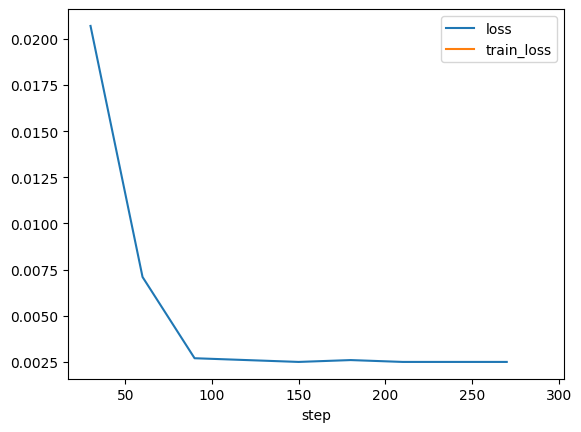

In [21]:
fig, ax = plt.subplots()
eval_loss = log_history[["step", "loss"]].dropna().plot(x="step", ax=ax)
train_loss = log_history[["step", "train_loss"]].dropna().plot(x="step", ax=ax)
fig.show()